# 2D Similarity Search

## Objectives:
- Load the ACHE dataset from GitHub.
- Compute **Morgan fingerprints**.
- Calculate **Tanimoto similarity** between each reference drug against every molecule in the dataset.
- Compare **two scenarios**:
  - **Scenario I**: Only actives and inactives.
  - **Scenario II**: Actives vs. (Inactives + Decoys).

Results obtained are:
- Tanimoto Similarity Scores
- EF1%, NEF1%
- ROC curves

---
### 1. Importing required libraries


In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.metrics import roc_curve, auc

### 2.Defining the four FDA-approved ACHE inhibitors with their SMILES

In [4]:
reference_drugs = {
    "Donepezil": "COc1cc2c(cc1OC)C(=O)C(CC1CCN(Cc3ccccc3)CC1)C2",
    "Rivastigmine": "CCN(C)C(=O)OC1=CC=CC(=C1)[C@H](C)N(C)C",
    "Galantamine": "COc1ccc2c3c1O[C@H]1C[C@@H](O)C=C[C@@]31CCN(C)C2",
    "Tacrine": "Nc1c2c(nc3ccccc13)CCCC2"
}

### 3. Function to compute Morgan fingerprints

In [6]:
def compute_morgan_fingerprint(smiles, radius=2, n_bits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return None

### 4. Function to calculate Tanimoto similarity

In [8]:
# Returns 0 if any fingerprint is None

def tanimoto_similarity(fp1, fp2):
    if fp1 is None or fp2 is None:
        return 0
    return DataStructs.TanimotoSimilarity(fp1, fp2)

### 5. Loading ACHE dataset from GitHub

In [10]:
base_url = "https://raw.githubusercontent.com/vktrannguyen/MLSF-protocol/main/ACHE/Own_data/SMILES/"

files = {
    "actives": "ACHE-actives.smi",
    "inactives": "ACHE-inactives.smi",
    "decoys": "ACHE-decoys-selected.smi"
}

def load_smiles_file(file_url):
    df = pd.read_csv(file_url, sep=" ", names=["SMILES", "ID"], header=None)
    return df

# Read the data
ache_data = {key: load_smiles_file(base_url + filename) for key, filename in files.items()}

### 6. Computing Morgan fingerprints for each set

In [12]:
for key, df in ache_data.items():
    df["Morgan_fp"] = df["SMILES"].apply(compute_morgan_fingerprint)
    df.dropna(subset=["Morgan_fp"], inplace=True)

# Prepare Scenario I (Actives + Inactives)
scenario1_df = pd.concat([
    ache_data["actives"],
    ache_data["inactives"]
], ignore_index=True)

# Prepare Scenario II (Actives + Inactives + Decoys)
scenario2_df = pd.concat([
    ache_data["actives"],
    ache_data["inactives"],
    ache_data["decoys"]
], ignore_index=True)

[22:40:47] DEPRECATION WARNING: please use MorganGenerator
[22:40:47] DEPRECATION WARNING: please use MorganGenerator
[22:40:47] DEPRECATION WARNING: please use MorganGenerator
[22:40:47] DEPRECATION WARNING: please use MorganGenerator
[22:40:47] DEPRECATION WARNING: please use MorganGenerator
[22:40:47] DEPRECATION WARNING: please use MorganGenerator
[22:40:47] DEPRECATION WARNING: please use MorganGenerator
[22:40:47] DEPRECATION WARNING: please use MorganGenerator
[22:40:47] DEPRECATION WARNING: please use MorganGenerator
[22:40:47] DEPRECATION WARNING: please use MorganGenerator
[22:40:47] DEPRECATION WARNING: please use MorganGenerator
[22:40:47] DEPRECATION WARNING: please use MorganGenerator
[22:40:47] DEPRECATION WARNING: please use MorganGenerator
[22:40:47] DEPRECATION WARNING: please use MorganGenerator
[22:40:47] DEPRECATION WARNING: please use MorganGenerator
[22:40:47] DEPRECATION WARNING: please use MorganGenerator
[22:40:47] DEPRECATION WARNING: please use MorganGenerat

### 7. Computing and storing Tanimoto similarities in each scenario for each reference drug

In [14]:
# We'll store them in separate columns in scenario1_df and scenario2_df

reference_fps = {
    drug: compute_morgan_fingerprint(smiles)
    for drug, smiles in reference_drugs.items()
}

# Scenario I: Compute Tanimoto for every molecule
for drug, ref_fp in reference_fps.items():
    col_name = f"{drug}_similarity_scenario1"
    scenario1_df[col_name] = scenario1_df["Morgan_fp"].apply(
        lambda fp: tanimoto_similarity(ref_fp, fp)
    )

# Scenario II: Compute Tanimoto for every molecule
for drug, ref_fp in reference_fps.items():
    col_name = f"{drug}_similarity_scenario2"
    scenario2_df[col_name] = scenario2_df["Morgan_fp"].apply(
        lambda fp: tanimoto_similarity(ref_fp, fp)
    )

[22:40:54] DEPRECATION WARNING: please use MorganGenerator
[22:40:54] DEPRECATION WARNING: please use MorganGenerator
[22:40:54] DEPRECATION WARNING: please use MorganGenerator
[22:40:54] DEPRECATION WARNING: please use MorganGenerator


### 8. Function to compute EF1% and NEF1% given a DataFrame, a reference-drug similarity column, and the 'Active' label

In [16]:
def compute_ef1_nef1(df: pd.DataFrame, sim_col: str, active_ids: pd.Series):
    ranked = df.copy()
    # Sort descending by similarity
    ranked = ranked.sort_values(by=sim_col, ascending=False)

    # Label actives
    ranked["Active"] = ranked["ID"].apply(
        lambda x: "Active" if x in active_ids.values else "Inactive"
    )

    # EF1% and NEF1%
    N = len(ranked)
    n = max(1, N // 100)  # top 1%
    A = (ranked["Active"] == "Active").sum()
    a = (ranked.iloc[:n]["Active"] == "Active").sum()

    EF1 = (100 * a / A) if A > 0 else 0
    EF1max = min(100, 100.0 * n / A) if (A > 0 and n > 0) else 100
    NEF1 = EF1 / EF1max if EF1max > 0 else 0

    return EF1, NEF1

### 9. Compute and print EF1% and NEF1% for both scenarios and each reference drug

In [18]:
for drug in reference_drugs.keys():
    # Scenario I
    col1 = f"{drug}_similarity_scenario1"
    EF1_1, NEF1_1 = compute_ef1_nef1(
        scenario1_df,
        col1,
        ache_data["actives"]["ID"]
    )

    # Scenario II
    col2 = f"{drug}_similarity_scenario2"
    EF1_2, NEF1_2 = compute_ef1_nef1(
        scenario2_df,
        col2,
        ache_data["actives"]["ID"]
    )

    print(f"\n{drug}")
    print(f"Scenario I => EF1%: {EF1_1:.2f}, NEF1%: {NEF1_1:.2f}")
    print(f"Scenario II => EF1%: {EF1_2:.2f}, NEF1%: {NEF1_2:.2f}")



Donepezil
Scenario I => EF1%: 1.78, NEF1%: 1.00
Scenario II => EF1%: 7.10, NEF1%: 0.14

Rivastigmine
Scenario I => EF1%: 1.18, NEF1%: 0.67
Scenario II => EF1%: 1.78, NEF1%: 0.03

Galantamine
Scenario I => EF1%: 0.59, NEF1%: 0.33
Scenario II => EF1%: 5.92, NEF1%: 0.11

Tacrine
Scenario I => EF1%: 1.18, NEF1%: 0.67
Scenario II => EF1%: 40.24, NEF1%: 0.77


### 10. Boxplot of Similarity Scores

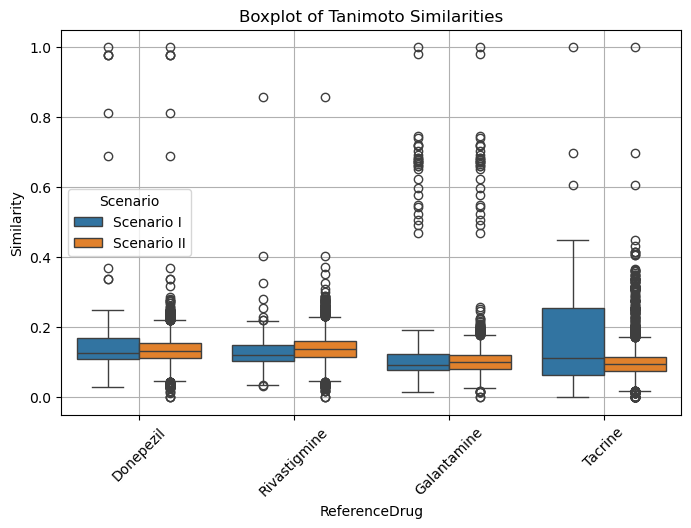

In [20]:
# Merge all similarity columns into a single long DataFrame for easy plotting
rows = []
for drug in reference_drugs.keys():
    # Scenario I
    for val in scenario1_df[f"{drug}_similarity_scenario1"]:
        rows.append((drug, "Scenario I", val))
    # Scenario II
    for val in scenario2_df[f"{drug}_similarity_scenario2"]:
        rows.append((drug, "Scenario II", val))

similarity_long = pd.DataFrame(rows, columns=["ReferenceDrug", "Scenario", "Similarity"])

plt.figure(figsize=(8,5))
sns.boxplot(x="ReferenceDrug", y="Similarity", hue="Scenario", data=similarity_long)
plt.title("Boxplot of Tanimoto Similarities")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### 11. Bar Plot of EF1% and NEF1% Comparisons

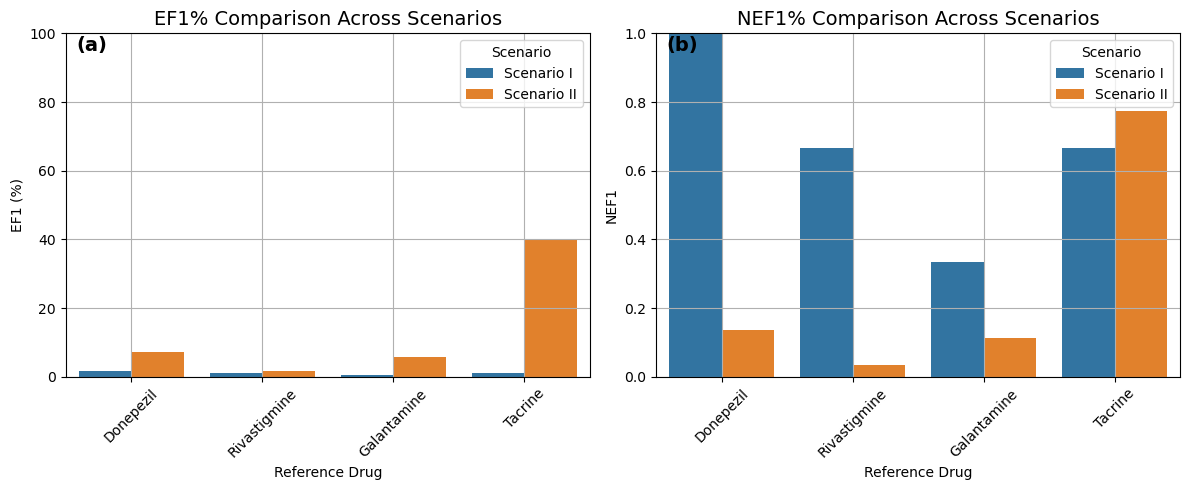

In [22]:
ef_data = []
for drug in reference_drugs.keys():
    col1 = f"{drug}_similarity_scenario1"
    EF1_1, NEF1_1 = compute_ef1_nef1(scenario1_df, col1, ache_data["actives"]["ID"])
    
    col2 = f"{drug}_similarity_scenario2"
    EF1_2, NEF1_2 = compute_ef1_nef1(scenario2_df, col2, ache_data["actives"]["ID"])
    
    ef_data.append((drug, "Scenario I", EF1_1, NEF1_1))
    ef_data.append((drug, "Scenario II", EF1_2, NEF1_2))

ef_df = pd.DataFrame(ef_data, columns=["ReferenceDrug", "Scenario", "EF1", "NEF1"])

# === Single figure with 2 subplots side-by-side ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x="ReferenceDrug", y="EF1", hue="Scenario", data=ef_df, ax=axes[0])
axes[0].set_title("EF1% Comparison Across Scenarios", fontsize=14)
axes[0].set_xlabel("Reference Drug")
axes[0].set_ylabel("EF1 (%)")
axes[0].set_ylim(0, 100)
axes[0].tick_params(axis="x", rotation=45)
axes[0].grid(True)
axes[0].annotate("(a)", xy=(0.02, 0.95), xycoords="axes fraction", fontsize=14, fontweight="bold")

sns.barplot(x="ReferenceDrug", y="NEF1", hue="Scenario", data=ef_df, ax=axes[1])
axes[1].set_title("NEF1% Comparison Across Scenarios", fontsize=14)
axes[1].set_xlabel("Reference Drug")
axes[1].set_ylabel("NEF1")
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis="x", rotation=45)
axes[1].grid(True)
axes[1].annotate("(b)", xy=(0.02, 0.95), xycoords="axes fraction", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

### 12. ROC Curves

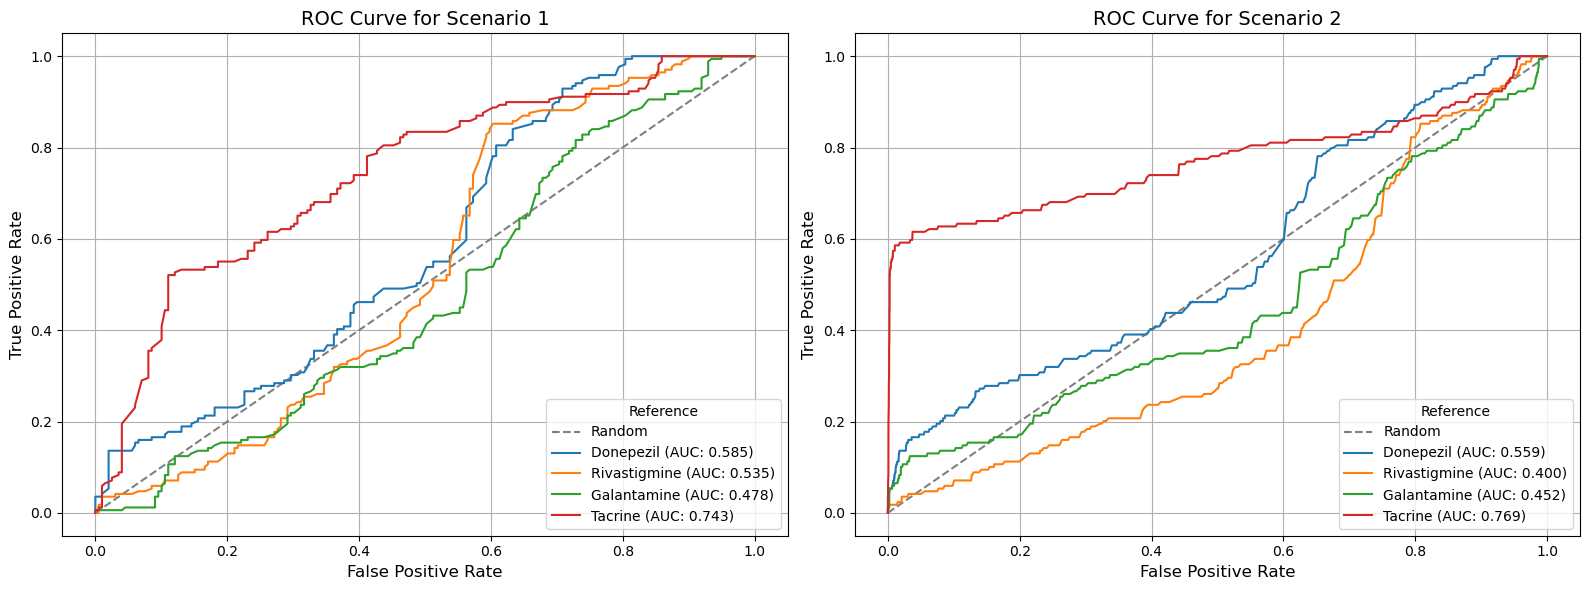

In [24]:
label_scenario1 = np.concatenate([
    np.repeat(1, ache_data['actives'].shape[0]),
    np.repeat(0, ache_data['inactives'].shape[0])
])
label_scenario2 = np.concatenate([
    np.repeat(1, ache_data['actives'].shape[0]),
    np.repeat(0, ache_data['inactives'].shape[0]),
    np.repeat(0, ache_data['decoys'].shape[0])
])

label = [label_scenario1, label_scenario2]
scenario = [scenario1_df, scenario2_df]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))  

for i in range(2):
    label_ = label[i]
    scenario_ = scenario[i]
    ax = axs[i]
    
    # Plot the random classifier line
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
    
    for j in range(3, 7):
        col_name = scenario_.columns[j]
        # Get just the drug name (everything before '_similarity_scenario')
        drug_name = col_name.split("_similarity_scenario")[0]
        
        fpr, tpr, _ = roc_curve(label_, scenario_.iloc[:, j].to_list())
        auc_value = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'{drug_name} (AUC: {auc_value:.3f})')

    ax.set_title(f'ROC Curve for Scenario {i+1}', fontsize=14)
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.grid(True)
    ax.legend(title="Reference", loc="lower right")  

plt.tight_layout()
plt.show()
